<a href="https://colab.research.google.com/github/Thehunk1206/Arduino-Surrounding-Sound-Classifier/blob/master/audio_classifier_for_mcu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Classifier for Micro Controller Unit (here: Arduino Nano BLE Sense)

In [1]:
%cd drive/MyDrive/audio_classifier_mcu/

/content/drive/MyDrive/audio_classifier_mcu


In [ ]:
!nvidia-smi

## Importing stuff

In [3]:
import os
import glob


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import models


tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
seed = 6
tf.random.set_seed(seed)
# np.random.seed(seed)

## Some Constants

In [4]:
# Audio related
SAMPLE_RATE = 16000
FRAME_SIZE_MS = 30 
FRAME_STRIDE_MS = 20

FRAME_SIZE = int(SAMPLE_RATE*(FRAME_SIZE_MS/1000))
FRAME_STRIDE = int(SAMPLE_RATE*(FRAME_STRIDE_MS/1000)) 
TAKE_MEAN_AT_INTERVAL = 6
FREQ_BIN = 49 # Specific only for this project
AVERAGED_FRAME_LENGTH = 42 #Specific only for this project


#ML related
DATA_DIR = 'Dataset/'
BATCH_SIZE = 32
LR = 2e-3
EPOCHS = 20
KERAS_MODEL = 'audio_classifier_float.h5'
FLOAT_TFLITE_MODEL = 'float_tflite_model.tflite'
INTONLY_QUANT_TFLITE_MODEL = 'intonly_quant_tflite_model.tflite'

## Splitting Dataset Files

In [5]:
LABELS = np.array(os.listdir(DATA_DIR))
LABEL_IDS = [i for i in range(len(LABELS))]
LABEL_ONE_HOT = tf.one_hot(LABEL_IDS, len(LABELS), axis=-1)

def audio_datasets_path(data_dir: str, train_split: float = 0.7, val_split: float= 0.1, test_split:float = 0.2):
    all_audio_filenames = glob.glob(data_dir+"/*/*")
    all_audio_filenames = tf.random.shuffle(all_audio_filenames)

    train = all_audio_filenames[0:int(len(all_audio_filenames)*train_split)]
    val = all_audio_filenames[len(train):len(train)+int(len(all_audio_filenames)*val_split)]
    test = all_audio_filenames[-int(len(all_audio_filenames)*test_split):]

    return train, val, test

LABELS

array(['FAN', 'BACKGROUND', 'GLASS_BREAK', 'PEOPLE_PRESENCE'],
      dtype='<U15')

In [6]:
train_audio_files, val_audio_files, test_audio_files = audio_datasets_path(DATA_DIR)
print(f'Train set       : {len(train_audio_files)}')
print(f'Validation set  : {len(val_audio_files)}')
print(f'Test set        : {len(test_audio_files)}')


Train set       : 2495
Validation set  : 356
Test set        : 713


## Reading Raw Audio and Label

In [7]:
def get_label(audio_file_path: str):
    string_parts = tf.strings.split(audio_file_path, os.path.sep)
    return string_parts[-2]


def get_waveform_from_audio_file(audio_file:str):
    '''
    The audio is of 16-bit PCM i.e values ranging from -32768 to 32767
    tf.audio.decode_wav normalizes the data between [-1.0,1.0]
    '''
    audio_binary = tf.io.read_file(audio_file)
    audio_raw, _ = tf.audio.decode_wav(audio_binary,desired_channels=1)
    return tf.squeeze(audio_raw, axis=-1)


def get_waveform_and_label(audio_file:str):
    label = get_label(audio_file)
    waveform = get_waveform_from_audio_file(audio_file)

    return waveform, label


## Creating Spectogram from Raw Audio

In [9]:
def get_spectrogram_from_raw_audio(waveform: tf.Tensor, frame_size:int = 256, frame_stride:int=128):
    '''
    Zero padding tha waveform to sampling Rate in case some file have less than 1600 values
    '''
    if [SAMPLE_RATE] - tf.shape(waveform) >= 0:
        zero_padding = tf.zeros([SAMPLE_RATE] - tf.shape(waveform), dtype=tf.float32)
        waveform = tf.cast(waveform, tf.float32)
        equal_length_of_waveform = tf.concat([waveform, zero_padding], 0)
    else:
        waveform = tf.cast(waveform, tf.float32)
        equal_length_of_waveform = waveform[:SAMPLE_RATE]
    spectrogram = tf.signal.stft(
        equal_length_of_waveform, frame_length=frame_size, frame_step=frame_stride)

    spectrogram = tf.abs(spectrogram)

    return spectrogram


def get_spectrogram_and_label(waveform: tf.Tensor, label: str):
    '''
    Get both spectrogram and corresponding label_id
    '''
    spectrogram = get_spectrogram_from_raw_audio(waveform,frame_size=FRAME_SIZE, frame_stride=FRAME_STRIDE)
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, axis=1),
        window_shape = [1,TAKE_MEAN_AT_INTERVAL],
        strides = [1,TAKE_MEAN_AT_INTERVAL],
        pooling_type='AVG',
        padding='VALID'
    )
    spectrogram = tf.squeeze(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    # Flatten the spectrogram
    spectrogram = tf.reshape(spectrogram, [-1])
    label_id = tf.argmax(label == LABELS)
    label = LABEL_ONE_HOT[label_id]

    return spectrogram, label

## Creating Data Pipeline using tf.data

In [10]:
def preprocess_data(audio_files: tf.Tensor):
    audio_files_ds = tf.data.Dataset.from_tensor_slices(audio_files)
    output_waveform_ds = audio_files_ds.map(
        get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE
    )
    output_spectrogram_ds = output_waveform_ds.map(
        get_spectrogram_and_label, num_parallel_calls = tf.data.AUTOTUNE
    )
    output_spectrogram_ds.shuffle(buffer_size=300)
    output_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

    output_spectrogram_ds

    return output_spectrogram_ds

train_ds = preprocess_data(train_audio_files)
val_ds = preprocess_data(val_audio_files)
test_ds = preprocess_data(test_audio_files)

In [9]:
for spectrogram,label in train_ds.take(1):
    # reshape_to = spectrogram.shape[0]*spectrogram.shape[1]
    # spectrogram = spectrogram.numpy().flatten().reshape(1,reshape_to)
    print(spectrogram.shape)

(2058,)


## Plotting Spectrograms with label

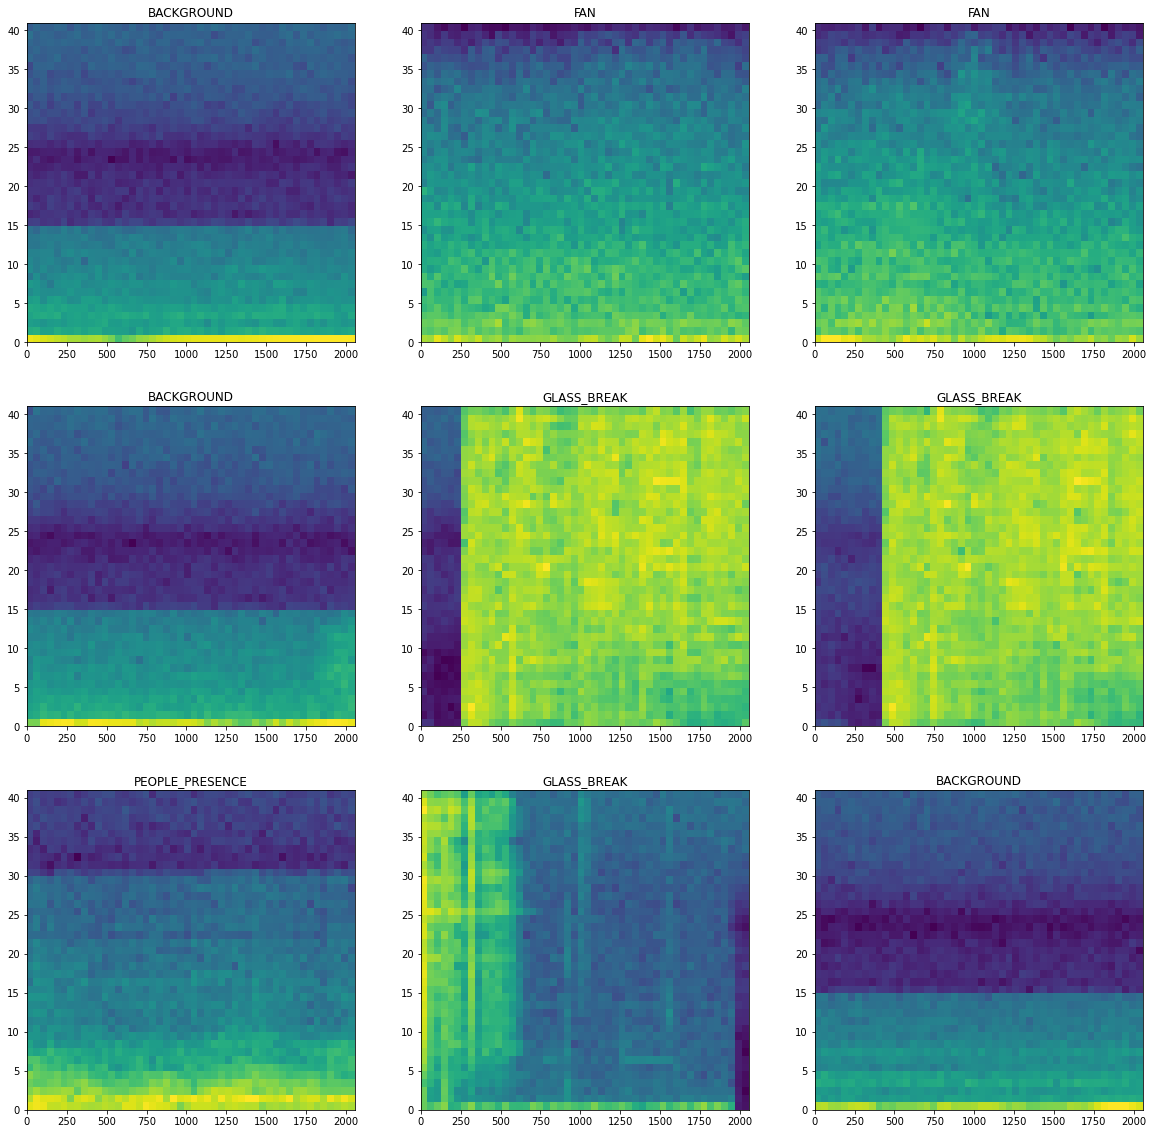

In [10]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
for i, (spectrogram, label) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  spectrogram = np.reshape(spectrogram.numpy(),(FREQ_BIN,AVERAGED_FRAME_LENGTH))
  plot_spectrogram(spectrogram, ax)
  ax.set_title(LABELS[tf.argmax(label)])
#   ax.axis('off')

plt.show()

## Model creating and training
 

### Keras Model 

In [11]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [12]:
# Get inputshape of spectrogram
for spectrogram,_ in train_ds.take(1):
    spectrogram_shape = spectrogram.shape
print(f'Input shape:{spectrogram_shape}')
num_of_labels = len(LABELS)

Input shape:(32, 2058)


In [13]:
# Create a simple CNN 
model = models.Sequential()
model.add(layers.Reshape((FREQ_BIN,AVERAGED_FRAME_LENGTH,1),input_shape=(spectrogram_shape[1],)))
model.add(layers.Conv2D(8, kernel_size=3, activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(1)))
model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(16, kernel_size=3, activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(1)))
model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_constraint=tf.keras.constraints.MaxNorm(1)))
model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(num_of_labels, activation='softmax', name='y_pred'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 49, 42, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 42, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 21, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 21, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 21, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 11, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 11, 16)        0

### Model compiling and Training

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy', Precision(), Recall()],
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=KERAS_MODEL,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds,callbacks=model_checkpoint_callback)

Epoch 1/20
78/78 [==============================] - 938s 12s/step - loss: 0.5006 - accuracy: 0.8152 - precision: 0.9152 - recall: 0.7054 - val_loss: 0.1811 - val_accuracy: 0.9438 - val_precision: 0.9758 - val_recall: 0.9045
Epoch 2/20
78/78 [==============================] - 49s 636ms/step - loss: 0.1786 - accuracy: 0.9475 - precision: 0.9564 - recall: 0.9407 - val_loss: 0.1888 - val_accuracy: 0.9298 - val_precision: 0.9424 - val_recall: 0.9185
Epoch 3/20
78/78 [==============================] - 52s 671ms/step - loss: 0.1386 - accuracy: 0.9507 - precision: 0.9589 - recall: 0.9455 - val_loss: 0.2263 - val_accuracy: 0.9045 - val_precision: 0.9244 - val_recall: 0.8933
Epoch 4/20
78/78 [==============================] - 53s 681ms/step - loss: 0.1387 - accuracy: 0.9607 - precision: 0.9659 - recall: 0.9543 - val_loss: 0.1744 - val_accuracy: 0.9270 - val_precision: 0.9506 - val_recall: 0.9185
Epoch 5/20
78/78 [==============================] - 53s 677ms/step - loss: 0.1167 - accuracy: 0.9663 

### Plotting loss and accuracy over epochs

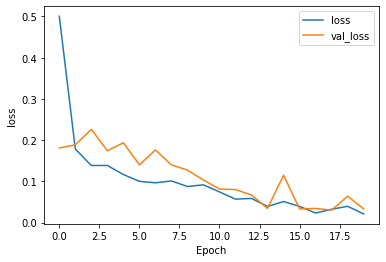

In [21]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

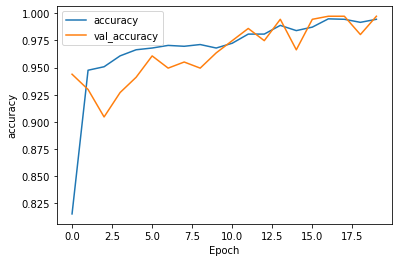

In [22]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Model Testing

In [10]:
model = models.load_model(KERAS_MODEL)

In [11]:
for spec,_ in test_ds.take(1):
    print(spec.shape)

(2058,)


In [12]:
test_ds = test_ds.batch(1)
model_test_score = model.evaluate(test_ds)

713/713 [==============================] - 206s 290ms/step - loss: 0.0314 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9958


In [21]:
print(f'=========Final Test result============\n',
      f'Accuracy    : {round(model_test_score[1] *100, 1)}%\n',
      f'Precision   : {round(model_test_score[2] , 3)}\n',
      f'Recall      : {round(model_test_score[3] , 3)}\n')

=========Final Test result============
 Accuracy    : 99.7%
 Precision   : 0.997
 Recall      : 0.996



## Quantization of Model

### Converting keras h5 model to tflite float model


In [11]:
model = models.load_model(KERAS_MODEL)

converter_for_float = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter_for_float.convert()
size_of_float_model = open(FLOAT_TFLITE_MODEL, 'wb').write(tflite_float_model)
print(f'Total size of {FLOAT_TFLITE_MODEL} is {size_of_float_model} Bytes')

INFO:tensorflow:Assets written to: /tmp/tmp15fxjl25/assets
Total size of float_tflite_model.tflite is 49544 Bytes


In [12]:
float_interpreter = tf.lite.Interpreter(model_content=tflite_float_model)
input_type = float_interpreter.get_input_details()[0]['dtype']
print('input dtype  : ', input_type)
output_type = float_interpreter.get_output_details()[0]['dtype']
print('output dtype : ', output_type)

input dtype  :  <class 'numpy.float32'>
output dtype :  <class 'numpy.float32'>


### Testing compressed tflite float32 Model

In [14]:
# Initialize the interpreter
interpreter_f = tf.lite.Interpreter(model_path=FLOAT_TFLITE_MODEL)
interpreter_f.allocate_tensors()

input_details = interpreter_f.get_input_details()[0]
output_details = interpreter_f.get_output_details()[0]

correct_predictions = 0
i = 0
for i,(spec,label) in tqdm(enumerate(test_ds.batch(1))):
    spec = spec.numpy()
    spec = spec.astype(input_details["dtype"])
    interpreter_f.set_tensor(input_details["index"], spec)
    interpreter_f.invoke()
    output = interpreter_f.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == np.argmax(label.numpy()[0]))

print(f'\n\nTotal Correct Prediction: {correct_predictions} out of: {i+1}')
print('\nFloat32 Quant model accuracy is %f%% (Number of test samples=%d)' % ((correct_predictions * 100) / (i+1), i+1))

713it [00:13, 54.13it/s]



Total Correct Prediction: 711 out of: 713

Float32 Quant model accuracy is 99.719495% (Number of test samples=713)


### Converting keras h5 model to tflite Integer-only quantized model for Microcontroller unit
> 1. Create a representative dataset to calibarate variable data.
> 2. Set the dtype of input and output of model to tf.int8

In [35]:
def representative_data_gen():
    for input_spec,_ in train_ds.batch(1).take(1):
        yield [input_spec] 

In [36]:
converter_int_model = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int_model.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int_model.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter_int_model.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int_model.inference_input_type = tf.uint8
converter_int_model.inference_output_type = tf.uint8

tflite_model_intonly_quant = converter_int_model.convert()
size_of_intonly_model = open(INTONLY_QUANT_TFLITE_MODEL, 'wb').write(tflite_model_intonly_quant)
print(f'Total size of {INTONLY_QUANT_TFLITE_MODEL} is {size_of_intonly_model} Bytes')

INFO:tensorflow:Assets written to: /tmp/tmpxuef6rjs/assets


INFO:tensorflow:Assets written to: /tmp/tmpxuef6rjs/assets


Total size of intonly_quant_tflite_model.tflite is 18208 Bytes


In [33]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_intonly_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input    : ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output   : ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Testing tflite intonly quantized model

In [37]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=INTONLY_QUANT_TFLITE_MODEL)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

correct_predictions = 0
i = 0
for i,(spec,label) in tqdm(enumerate(test_ds.batch(1))):
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      spec = spec.numpy().reshape(1,FREQ_BIN*AVERAGED_FRAME_LENGTH)
      spec = spec / input_scale + input_zero_point
    spec = spec.astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], spec)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == np.argmax(label.numpy()[0]))
print(f'\nTotal Correct Prediction: {correct_predictions} out of: {i+1}')
print('\nInt-only Quant model accuracy is %f%% (Number of test samples=%d)' % ((correct_predictions * 100) / (i+1), i+1))

713it [00:16, 42.19it/s]


Total Correct Prediction: 664 out of: 713

Int-only Quant model accuracy is 93.127630% (Number of test samples=713)


## Generating model.cc file from intonly_quant_tflite_model for MCU

In [38]:
!apt-get update && apt-get -qq install xxd

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [607 kB]
Get:13 http:

In [39]:
!xxd -i {INTONLY_QUANT_TFLITE_MODEL} > model.cc

In [40]:
!head -n 20 model.cc

unsigned char intonly_quant_tflite_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00,
  0xa8, 0x2e, 0x00, 0x00, 0xb8, 0x2e, 0x00, 0x00, 0x2c, 0x46, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x1f, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x20, 0x00, 0x00, 0x00, 0x58, 0x2e, 0x00, 0x00, 0x50, 0x2e, 0x00, 0x00,
  0x3c, 0x2e, 0x00, 0x00, 0x28, 0x2e, 0x00, 0x00, 0x14, 0x2e, 0x00, 0x00,
  0x00, 0x2e, 0x00, 0x00, 0xec, 0x2d, 0x00, 0x00, 0xd4, 0x

In [41]:
!tail -n 20 model.cc

  0x69, 0x6e, 0x70, 0x75, 0x74, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0a, 0x08, 0x00, 0x00, 0x09, 0x00, 0x00, 0x00,
  0xac, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00, 0x80, 0x00, 0x00, 0x00,
  0x70, 0x00, 0x00, 0x00, 0x60, 0x00, 0x00, 0x00, 0x4c, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff,
  0x11, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x11,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03, 0xd0, 0xff, 0xff, 0xff, 0x16, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x16, 0xdc, 0xff, 0xff, 0xff, 0x53, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x53, 0xe8, 0xff, 